# 3 Additional Functions with Keras

- 3.1 모델 합치기 with CIFAR10
- 3.2 데이터 증강
- 3.3 Finetuning

## 3.1 모델 합치기 with CIFAR10

convolution과 maxpooling layer로 구성된 feature extractor 모델과

fully connected layer로 구성된 ANN classifier 모델을 따로 정의하고

두 모델을 합쳐서 CNN 모델을 만듬

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(4)

### (1) 데이터셋 : CIFAR 10

170498071/170498071 [==============================] - 65s 0us/step
(50000, 32, 32, 3) (50000, 1)
label :  [6]
(50000, 32, 32, 3) (50000, 10)


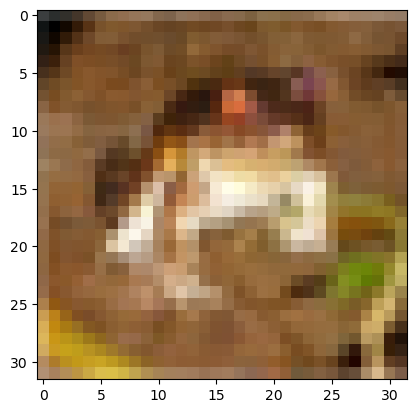

In [2]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets

# Dataset Load
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

# Dataset Confirm
print(X_train.shape, Y_train.shape)
print('label : ',Y_train[0])
plt.imshow(X_train[0])

# Dataset Preprocessing
X_train = X_train/255.0
X_test = X_test/255.0
Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

### (2) 모델링

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [5]:
n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

def conv_maxpool_layers(n_in):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(n_in)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fc_layers(n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(2048,), activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def CNN_sum(n_in, n_out):
    
    # Coding Time
    
    #각 부분 모델
    feature_extractor=conv_maxpool_layers(n_in)
    feature_extractor.trainable=True # .trainable : 해당 layer에 대한 학습 여부 결정
    ann_classifier = fc_layers(n_out)
    ann_classifier.trainable=True
    
    #두 모델을 합쳐 새로운 모델 정의(Functional Style)
    x = Input(shape=n_in)
    feature = feature_extractor(x)
    y = ann_classifier(feature)
    model = Model(inputs = x, outputs = y)
    '''
    Sequential Style
    model = Sequential()
    model.add(feature_extractor)
    model.add(ann_classifier)
    '''
    return model

In [6]:
model = CNN_sum(n_in, n_out)
model.summary()

Metal device set to: Apple M1 Max
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 2048)              5088      
                                                                 
 sequential_1 (Sequential)   (None, 10)                263562    
                                                                 
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
_________________________________________________________________


### (3-4) 모델의 학습과정 설정 / 모델 학습

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50


2023-04-04 10:01:45.127248: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 5s 13ms/step - loss: 1.6309 - accuracy: 0.4145 - val_loss: 1.4141 - val_accuracy: 0.4977
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 1.2755 - accuracy: 0.5465 - val_loss: 1.2399 - val_accuracy: 0.5621
Epoch 3/50
313/313 [==============================] - 4s 13ms/step - loss: 1.1358 - accuracy: 0.6034 - val_loss: 1.1369 - val_accuracy: 0.5994
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 1.0460 - accuracy: 0.6358 - val_loss: 1.0899 - val_accuracy: 0.6210
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 0.9730 - accuracy: 0.6603 - val_loss: 1.0705 - val_accuracy: 0.6253
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 0.9124 - accuracy: 0.6851 - val_loss: 1.0150 - val_accuracy: 0.6532
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 0.8617 - accuracy: 0.7018 - val_loss: 1.0016 - val_accuracy: 0.6554
Epoch 8/50

### (5) 모델 평가

In [8]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 6ms/step - loss: 1.0527 - accuracy: 0.6656
loss : 1.0527, accruracy : 0.6656


## 3.2 Image data augmentation
케라스에서는 ImageDataGenerate 함수로 Data augmentation 기능을  제공

https://keras.io/preprocessing/image/#imagedatagenerator-class

### (1)-2 데이터 증강 적용

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [10]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 2, # 회전
    zoom_range = 0.1, # 확대 축소
    width_shift_range = 0.1, # 수평 이동
    height_shift_range = 0.1, # 수직 이동
    horizontal_flip = True, # 수평 반전|
    vertical_flip = False # 수직 반전
)

datagen.fit(X_train)

### (3-4) 모델의 학습과정 설정 / 모델 학습

In [11]:
model = CNN_sum(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
# Coding Time
model.fit(datagen.flow(X_train[:-10000], Y_train[:-10000], batch_size = 128), 
          epochs = 50, validation_data = (X_train[-10000:], Y_train[-10000:]), verbose = 1, callbacks = [earlystopper])


Epoch 1/50
313/313 [==============================] - 9s 28ms/step - loss: 1.6957 - accuracy: 0.3938 - val_loss: 1.4332 - val_accuracy: 0.4837
Epoch 2/50
313/313 [==============================] - 9s 28ms/step - loss: 1.3922 - accuracy: 0.5036 - val_loss: 1.2531 - val_accuracy: 0.5641
Epoch 3/50
313/313 [==============================] - 9s 28ms/step - loss: 1.2803 - accuracy: 0.5438 - val_loss: 1.1830 - val_accuracy: 0.5771
Epoch 4/50
313/313 [==============================] - 9s 27ms/step - loss: 1.2183 - accuracy: 0.5671 - val_loss: 1.1267 - val_accuracy: 0.6027
Epoch 5/50
313/313 [==============================] - 9s 28ms/step - loss: 1.1656 - accuracy: 0.5907 - val_loss: 1.0724 - val_accuracy: 0.6251
Epoch 6/50
313/313 [==============================] - 8s 27ms/step - loss: 1.1233 - accuracy: 0.6042 - val_loss: 1.1459 - val_accuracy: 0.6013
Epoch 7/50
313/313 [==============================] - 9s 28ms/step - loss: 1.0898 - accuracy: 0.6160 - val_loss: 1.0470 - val_accuracy: 0.6336

In [12]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 7ms/step - loss: 0.8250 - accuracy: 0.7271
loss : 0.8250, accruracy : 0.7271


## 3.3 Transfer learning
Transfer learning을 통해 현재 쓰이고 있는 네트워크를 가져와 학습하는 방법을 배워본다(Classifier만 / Entire)

### (2) 모델링1 : Classifier learning
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [14]:
# Coding Time
base_model = VGG16(weights='imagenet', input_shape=(32,32,3), include_top=False)
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [15]:
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(Y_train.shape[1], activation='softmax')(x) #Y_train.shape[1] :10 

model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [19]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 8s 22ms/step - loss: 1.7228 - accuracy: 0.4024 - val_loss: 1.3833 - val_accuracy: 0.5209
Epoch 2/50
313/313 [==============================] - 6s 20ms/step - loss: 1.5306 - accuracy: 0.4671 - val_loss: 1.3378 - val_accuracy: 0.5298
Epoch 3/50
313/313 [==============================] - 6s 20ms/step - loss: 1.4913 - accuracy: 0.4807 - val_loss: 1.3132 - val_accuracy: 0.5391
Epoch 4/50
313/313 [==============================] - 6s 20ms/step - loss: 1.4615 - accuracy: 0.4875 - val_loss: 1.2847 - val_accuracy: 0.5553
Epoch 5/50
313/313 [==============================] - 6s 19ms/step - loss: 1.4421 - accuracy: 0.4974 - val_loss: 1.2927 - val_accuracy: 0.5570
Epoch 6/50
313/313 [==============================] - 6s 20ms/step - loss: 1.4208 - accuracy: 0.4992 - val_loss: 1.2714 - val_accuracy: 0.5610
Epoch 7/50
313/313 [==============================] - 6s 20ms/step - loss: 1.4018 - accuracy: 0.5064 - val_loss: 1.2554 - val_accuracy: 0.5702

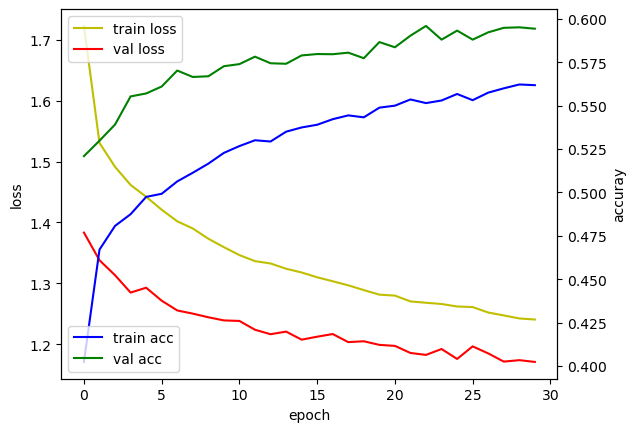

In [20]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [21]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 14ms/step - loss: 1.1968 - accuracy: 0.5855
loss : 1.1968, accruracy : 0.5855


### (2) 모델링1 : Entire
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [22]:
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
#x = Dense(128, activation='relu')(x) 
predictions = Dense(Y_train.shape[1], activation='softmax')(x) #Y_train.shape[1] :10 

model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# first: train the all layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

In [24]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [26]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 18s 54ms/step - loss: 1.9868 - accuracy: 0.1958 - val_loss: 1.7720 - val_accuracy: 0.2603
Epoch 2/50
313/313 [==============================] - 17s 53ms/step - loss: 1.6492 - accuracy: 0.3098 - val_loss: 1.7886 - val_accuracy: 0.3088
Epoch 3/50
313/313 [==============================] - 16s 53ms/step - loss: 1.3989 - accuracy: 0.4421 - val_loss: 1.3139 - val_accuracy: 0.4884
Epoch 4/50
313/313 [==============================] - 16s 52ms/step - loss: 1.1938 - accuracy: 0.5493 - val_loss: 1.1915 - val_accuracy: 0.5723
Epoch 5/50
313/313 [==============================] - 17s 53ms/step - loss: 1.0123 - accuracy: 0.6297 - val_loss: 1.1279 - val_accuracy: 0.6069
Epoch 6/50
313/313 [==============================] - 16s 52ms/step - loss: 0.8001 - accuracy: 0.7125 - val_loss: 0.9691 - val_accuracy: 0.6703
Epoch 7/50
313/313 [==============================] - 16s 52ms/step - loss: 0.6587 - accuracy: 0.7686 - val_loss: 0.9202 - val_accuracy:

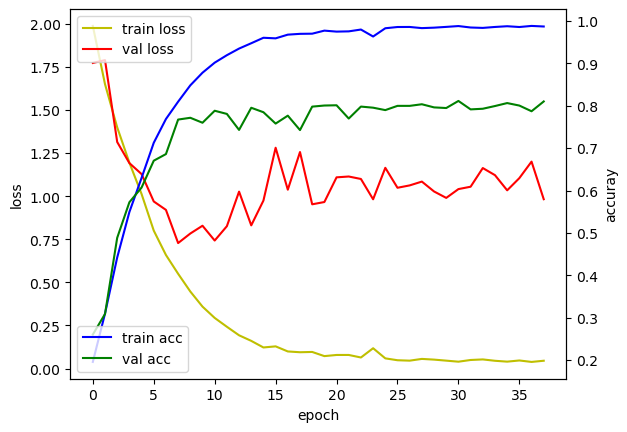

In [27]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [28]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 14ms/step - loss: 1.0576 - accuracy: 0.8074
loss : 1.0576, accruracy : 0.8074


# 3.4 Keras MNIST - 모델의 성능을 직접 높혀보자
 - CNN의 구조를 바꾸어 나만의 모델을 만들어보자
 - 목표 정확도: 99.5% 만들기
 - 바꿀 수 있는 하이퍼 파라미터: Learning Rate, Batch size, Epochs, Optimizer, Activation Function, 모델 레이어 구조, BN, DO, DA, Fine Tuning 등

## (1) 데이터셋

In [ ]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
print(X_train.shape, Y_train.shape)

In [ ]:
from tensorflow.keras import backend
backend.image_data_format()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

## (2) Keras 모델링

## (3) 모델의 학습과정 설정

## (4) 모델 학습시키기

## (5) 모델 평가하기